In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from time import perf_counter

First download the dataset with its informations.

In [ ]:
(data_train, data_test), data_info = tfds.load("cifar10", as_supervised=True, split=["train", "test"], with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete5I3LC4/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete5I3LC4/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


The dataset informations are necessary to now print out a few examples with their labels.

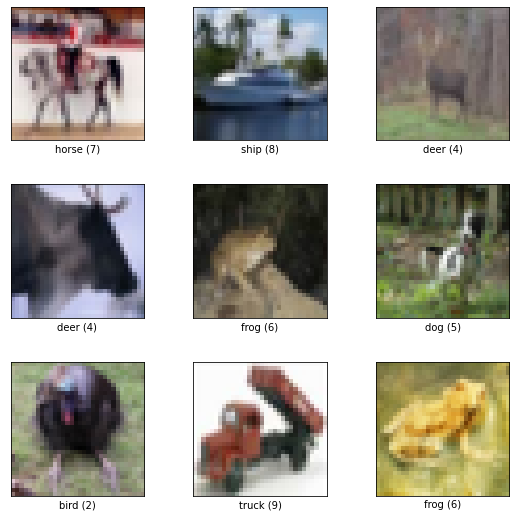

In [ ]:
fig = tfds.show_examples(data_train, data_info)

Let's get to preprocessing now: <br>
From the documentation of the cifar10 dataset we know that the images are all of size 32x32, so resizing won't be needed. <br>
Due to the dataset having 10 different labels, a onehot notation will be needed for the labels though. <br>
A normalisation seems to be reasonable as well, so we perform this too.


In [ ]:
# # Image normalisation really hurts convergence so we won't use it
# data_train = data_train.map(lambda sample, label: (tf.image.per_image_standardization(sample), tf.one_hot(label, 10)))
# data_test = data_test.map(lambda sample, label: (tf.image.per_image_standardization(sample), tf.one_hot(label, 10)))

data_train = data_train.map(lambda sample, label: (tf.cast(sample, tf.float32), tf.cast(tf.one_hot(label, 10), tf.float32)))
data_test = data_test.map(lambda sample, label: (tf.cast(sample, tf.float32), tf.cast(tf.one_hot(label, 10), tf.float32)))

Now we just have to batch and shuffle the data and we're ready for training.

In [ ]:
batch_size = 128

# We start by prefetching the data (The amout of samples to prefetch,
# will be left to the framework)
data_train = data_train.prefetch(tf.data.experimental.AUTOTUNE)
data_test = data_test.prefetch(tf.data.experimental.AUTOTUNE)

# Afterwards we will cache the data, so that we don't have to wait for normalising and
# onehot encoding if we do a second training run 
data_train = data_train.cache()
data_test = data_test.cache()

# Now the data will be shuffled and batched afterwards.
# Shuffeling before batching seems more reasonable, because that way we don't
# get the same batch with different internal order each training, but completely different
# batches instead.
data_train = data_train.shuffle(10000)
data_test = data_test.shuffle(10000)
data_train = data_train.batch(batch_size)
data_test = data_test.batch(batch_size)

In [ ]:
def acc_metric(target,output):
  # Check how many samples have the same prediction and target value and take the
  # mean which represents the accuracy
  acc = np.argmax(target, axis=1) == np.argmax(output, axis=1)
  acc = np.mean(acc)
 
  return acc

def train_step(model, input, target, loss_function, optimizer):
  # Train the model using gradient tape and return the loss for visualisation
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss 

def test(model, test_data, loss_function):
  # Get loss and accuracy of a dataset
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  acc_metric(target, prediction)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(sample_test_accuracy)

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

def train_model(num_epochs, learning_rate, model):
  tf.keras.backend.clear_session()

  running_average_factor = 0.95

  # Initialise the loss function for training
  # cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  train_losses, test_losses, test_accuracies = [],[],[]

  # Get the initial losses and the accuracy
  start = perf_counter()
  test_loss, test_accuracy = test(model, data_test, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  train_loss, _ = test(model, data_train, cross_entropy_loss)
  train_losses.append(train_loss)

  print((f"Init:" + " " *(len(str(num_epochs)) + 3) + " Accuracy: " + " " * (4 - len(str(round(test_accuracy * 100, 0)))) + f"{'{0:.3f}'.format(round(test_accuracy * 100, 3))}%,"
         f"  Loss: (Train: {'{0:.3f}'.format(round(float(train_losses[-1]), 3))},"
         f"  Test: {'{0:.3f}'.format(round(float(test_loss), 3))}),"
         f"  Overfitting Indicator: {'{0:+.3f}'.format(round(float(test_losses[-1] - train_losses[-1]), 3))},"
         f"  Time: {'{0:.2f}'.format(round(perf_counter() - start, 2))}s"))


  # TODO: What are these warnings??
  tf.get_logger().setLevel("ERROR")

  # Train the model (record the time as well for performance judgements)
  for epoch in range(1, num_epochs + 1):
      start = perf_counter()

      average = []
      for (input,target) in data_train:
          train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
          average.append(train_loss)
          
      train_losses.append(np.mean(average))
      
      test_loss, test_accuracy = test(model, data_test, cross_entropy_loss)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)

      print((f"Epoch #{epoch}:" + " " * (len(str(num_epochs)) - len(str(epoch))) +  f" Accuracy: {'{0:.3f}'.format(round(test_accuracy * 100, 3))}%,"
             f"  Loss: (Train: {'{0:.3f}'.format(round(float(train_losses[-1]), 3))},"
             f"  Test: {'{0:.3f}'.format(round(float(test_loss), 3))}),"
             f"  Overfitting Indicator: {'{0:+.3f}'.format(round(float(test_losses[-1] - train_losses[-1]), 3))},"
             f"  Time: {'{0:.2f}'.format(round(perf_counter() - start, 2))}s"))
      
  return train_losses, test_losses, test_accuracies

def plot_learning(train_losses, test_losses, test_accuracies, num_epochs):
  # draw the loss plot
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend((line1, line2), ("training", "test"))
  plt.show()

  # draw the accuracy plot
  line1, = plt.plot(test_accuracies)
  line2, = plt.plot([0.85] * (num_epochs + 1))
  line2.set_alpha(0.5)
  line2.set_color("green")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend((line1, line2), ("test", "targeted accuracy"))
  plt.show()

## ResNet

In [ ]:
# Implement a class for residual blocks
class residual_block(layers.Layer):
  def __init__(self, input_filters, l2_conv):
    super(residual_block, self).__init__()
    self.hidden_layers = []

    # Full pre-activation
    self.hidden_layers.append(layers.BatchNormalization())
    self.hidden_layers.append(layers.ReLU())
    self.hidden_layers.append(layers.Conv2D(filters=input_filters // 4, 
                                            kernel_size=1, 
                                            activation=None, 
                                            padding="same", 
                                            kernel_regularizer=tf.keras.regularizers.l2(l2_conv)))
    self.hidden_layers.append(layers.BatchNormalization())
    self.hidden_layers.append(layers.ReLU())
    self.hidden_layers.append(layers.Conv2D(filters=input_filters, 
                                            kernel_size=3, 
                                            activation=None, 
                                            padding="same", 
                                            kernel_regularizer=tf.keras.regularizers.l2(l2_conv)))
    self.addition_layer = layers.Add()

  @tf.function
  def call(self, x):
    x0 = x
    for layer in self.hidden_layers:
      x = layer(x)
    
    return self.addition_layer([x0, x])

In [ ]:
class ResNet_Model(tf.keras.Model):
  def __init__(self, res_filters, dense_units, l2_conv, l2_dense):
    super(ResNet_Model, self).__init__()
    self.hidden_layers = []

    # The first layer will be a simple convolutional layer
    self.hidden_layers.append(layers.Conv2D(filters=res_filters[0], 
                                            kernel_size=3, 
                                            activation=None, 
                                            padding="same", 
                                            kernel_regularizer=tf.keras.regularizers.l2(l2_conv),
                                            input_shape=(32,32,3)))
    # Add batch normalisation
    self.hidden_layers.append(layers.BatchNormalization())
    self.hidden_layers.append(layers.ReLU())
    self.hidden_layers.append(layers.MaxPooling2D(2, strides=1))

    for i in range(len(res_filters) - 1):
      self.hidden_layers.append(residual_block(res_filters[i], l2_conv))
      if (res_filters[i] < res_filters[i + 1]):
        self.hidden_layers.append(layers.Conv2D(filters=res_filters[i + 1], 
                                          kernel_size=1, 
                                          activation=None, 
                                          padding="same", 
                                          kernel_regularizer=tf.keras.regularizers.l2(l2_conv)))

    # In order to be able to work with the 2d data in normal dense layers
    # we will perform max pooling to turn it into 1d data
    self.hidden_layers.append(layers.GlobalAveragePooling2D())

    # Now we can create the dense layers specified by the input
    # We will use Batch Normalisation and Dropout to decrease overfitting
    for units in dense_units:
      self.hidden_layers.append(layers.Dense(units,
                                              activation=None,
                                              kernel_regularizer=tf.keras.regularizers.l2(l2_dense)))
      self.hidden_layers.append(layers.BatchNormalization())
      self.hidden_layers.append(layers.ReLU())

      self.hidden_layers.append(layers.Dropout(rate=0.5))

    # For our final layer we will of course use a softmax layer to normalise and
    # classify the results
    self.hidden_layers.append(layers.Dense(units=10, 
                                            activation="softmax", 
                                            kernel_regularizer=tf.keras.regularizers.l2(l2_dense)))

  @tf.function
  def call(self, x, training=True):
    for layer in self.hidden_layers:
      # Check if the type of the element is a list (= a residual block)
      if isinstance(layer, list):
        r = x
        for res_layer in layer:
          r = res_layer(x)
        
        # Now we add combine the Output and the Input of the residual block
        x = layers.Add()([x, r])
        x = layers.ReLU()(x)

      else:
        x = layer(x)

    return x

Init:      Accuracy: 10.156%,  Loss: (Train: 3.011,  Test: 3.018),  Overfitting Indicator: +0.007,  Time: 20.50s
Epoch #1:  Accuracy: 31.112%,  Loss: (Train: 1.896,  Test: 1.776),  Overfitting Indicator: -0.120,  Time: 54.28s
Epoch #2:  Accuracy: 36.828%,  Loss: (Train: 1.679,  Test: 1.638),  Overfitting Indicator: -0.041,  Time: 52.55s
Epoch #3:  Accuracy: 37.104%,  Loss: (Train: 1.603,  Test: 1.659),  Overfitting Indicator: +0.056,  Time: 52.50s
Epoch #4:  Accuracy: 43.028%,  Loss: (Train: 1.539,  Test: 1.539),  Overfitting Indicator: -0.000,  Time: 52.48s
Epoch #5:  Accuracy: 46.737%,  Loss: (Train: 1.446,  Test: 1.427),  Overfitting Indicator: -0.019,  Time: 52.31s
Epoch #6:  Accuracy: 50.415%,  Loss: (Train: 1.394,  Test: 1.372),  Overfitting Indicator: -0.022,  Time: 52.37s
Epoch #7:  Accuracy: 52.769%,  Loss: (Train: 1.354,  Test: 1.324),  Overfitting Indicator: -0.030,  Time: 52.31s
Epoch #8:  Accuracy: 53.491%,  Loss: (Train: 1.309,  Test: 1.310),  Overfitting Indicator: +0.00

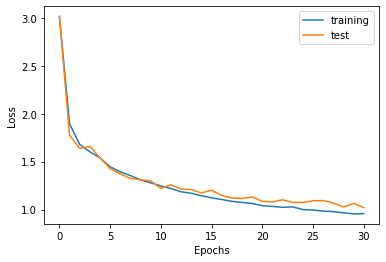

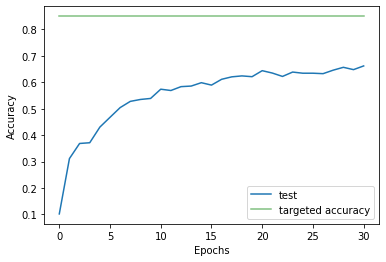

In [ ]:
num_epochs = 30
learning_rate = 0.0275
conv_filters = [64, 64, 64 , 128, 128]
dense_units = [256, 128, 64]
l2_conv = 0.02
l2_dense = 0.04

model = ResNet_Model(conv_filters, dense_units, l2_conv, l2_dense)

train_losses, test_losses, test_accuracies = train_model(num_epochs, learning_rate, model)

plot_learning(train_losses, test_losses, test_accuracies, num_epochs)

## DenseNet

In [ ]:
# Implement a class for dense blocks
class dense_block(layers.Layer):
  def __init__(self, input_filters, growth_factor, l2_conv):
    super(dense_block, self).__init__()
    self.hidden_layers = []

    # Full pre-activation
    self.hidden_layers.append(layers.BatchNormalization())
    self.hidden_layers.append(layers.ReLU())
    self.hidden_layers.append(layers.Conv2D(filters=input_filters // 4, 
                                            kernel_size=1, 
                                            activation=None, 
                                            padding="same", 
                                            kernel_regularizer=tf.keras.regularizers.l2(l2_conv)))
    self.hidden_layers.append(layers.BatchNormalization())
    self.hidden_layers.append(layers.ReLU())
    self.hidden_layers.append(layers.Conv2D(filters=growth_factor, 
                                            kernel_size=3, 
                                            activation=None, 
                                            padding="same", 
                                            kernel_regularizer=tf.keras.regularizers.l2(l2_conv)))
    self.concat_layer = layers.Concatenate(axis=-1)

  @tf.function
  def call(self, x):
    x0 = x
    for layer in self.hidden_layers:
      x = layer(x)
    
    return self.concat_layer([x0, x])

In [ ]:
class denseNet_Model(tf.keras.Model):
  def __init__(self, init_filter_size, dense_block_num, growth_factor, dense_units, l2_conv, l2_dense):
    super(denseNet_Model, self).__init__()
    self.hidden_layers = []

    # The first layer will be a simple convolutional layer
    self.hidden_layers.append(layers.Conv2D(filters=init_filter_size, 
                                            kernel_size=3, 
                                            activation=None, 
                                            padding="same", 
                                            kernel_regularizer=tf.keras.regularizers.l2(l2_conv),
                                            input_shape=(32,32,3)))
    
    for i in range(dense_block_num):
      self.hidden_layers.append(dense_block(init_filter_size + i * growth_factor, growth_factor, l2_conv))

    # In order to be able to work with the 2d data in normal dense layers
    # we will perform max pooling to turn it into 1d data
    self.hidden_layers.append(layers.GlobalAveragePooling2D())

    # Now we can create the dense layers specified by the input
    # We will use Batch Normalisation and Dropout to decrease overfitting
    for units in dense_units:
      self.hidden_layers.append(layers.Dense(units,
                                              activation=None,
                                              kernel_regularizer=tf.keras.regularizers.l2(l2_dense)))
      self.hidden_layers.append(layers.BatchNormalization())
      self.hidden_layers.append(layers.ReLU())

      self.hidden_layers.append(layers.Dropout(rate=0.5))

    # For our final layer we will of course use a softmax layer to normalise and
    # classify the results
    self.hidden_layers.append(layers.Dense(units=10, 
                                            activation="softmax", 
                                            kernel_regularizer=tf.keras.regularizers.l2(l2_dense)))

  @tf.function
  def call(self, x, training=True):
    for layer in self.hidden_layers:
      x = layer(x)

    return x

Init:      Accuracy: 10.047%,  Loss: (Train: 2.918,  Test: 2.960),  Overfitting Indicator: +0.042,  Time: 19.94s
Epoch #1:  Accuracy: 32.852%,  Loss: (Train: 1.905,  Test: 1.707),  Overfitting Indicator: -0.198,  Time: 58.86s
Epoch #2:  Accuracy: 41.129%,  Loss: (Train: 1.626,  Test: 1.523),  Overfitting Indicator: -0.103,  Time: 56.13s
Epoch #3:  Accuracy: 47.973%,  Loss: (Train: 1.464,  Test: 1.415),  Overfitting Indicator: -0.049,  Time: 56.15s
Epoch #4:  Accuracy: 53.619%,  Loss: (Train: 1.341,  Test: 1.283),  Overfitting Indicator: -0.058,  Time: 56.17s
Epoch #5:  Accuracy: 55.934%,  Loss: (Train: 1.246,  Test: 1.232),  Overfitting Indicator: -0.014,  Time: 56.17s
Epoch #6:  Accuracy: 60.700%,  Loss: (Train: 1.169,  Test: 1.130),  Overfitting Indicator: -0.040,  Time: 56.15s
Epoch #7:  Accuracy: 62.688%,  Loss: (Train: 1.099,  Test: 1.086),  Overfitting Indicator: -0.013,  Time: 56.14s
Epoch #8:  Accuracy: 64.201%,  Loss: (Train: 1.043,  Test: 1.067),  Overfitting Indicator: +0.02

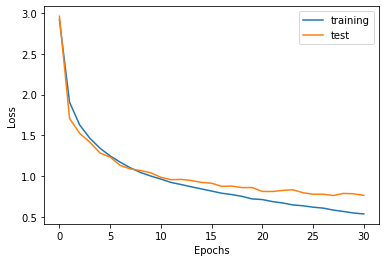

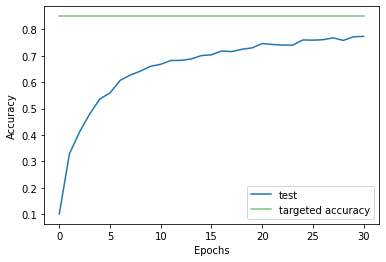

In [ ]:
num_epochs = 30
learning_rate = 0.0075
init_filter_size = 64
dense_block_num = 10
growth_factor =  32
dense_units = [512, 256, 128, 64]
l2_conv = 0.035
l2_dense = 0.06

model = denseNet_Model(init_filter_size, dense_block_num, growth_factor, dense_units, l2_conv, l2_dense)

train_losses, test_losses, test_accuracies = train_model(num_epochs, learning_rate, model)

plot_learning(train_losses, test_losses, test_accuracies, num_epochs)